In [1]:
import numpy as np
import pandas as pd
import helper_functions as hf
import keras_tuner as kt
from tensorflow.keras import callbacks
from tensorflow.keras import utils

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

compat_rename = {'Ultimate Tensile Strength': 'Tensile Strength, Ultimate',
                 'Yield Strength': 'Tensile Strength, Yield',
                 'Elongation': 'Elongation at Break',
                 'names': 'Name'}

In [2]:
nickel_data = pd.read_csv("full_set.csv", index_col=0)
# nickel_data = nickel_data.drop(columns="Name")
nickel_data = nickel_data.rename(columns=compat_rename)
nickel_data.head()

,Name,"Tensile Strength, Yield",Pressure treated,Area under heat treatment curve,Strengthening Precipitate Phase,Powder processed,Al,B,C,Co,...,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate",Elongation at Break
0,Allvac718PLUS,989.0,No,392890.0,GammaPrime,No,1.5,0.005,0.020,9.1,...,0.0,0.7,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,HastelloyS,NaN,No,0.0,NaN,No,0.3,0.000,0.000,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,845.0,NaN
2,Haynes230,NaN,No,0.0,NaN,No,0.3,0.000,0.100,0.0,...,0.0,0,0.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Waspaloy,NaN,No,19572.0,NaN,No,1.3,0.001,0.035,13.4,...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Unnamedalloy10,NaN,No,0.0,NaN,No,5.7,0.000,0.000,15.0,...,0.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train for UTS

In [3]:
# uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
# uts_data = uts_data.drop(
#     columns=['Tensile Strength, Yield', 'Elongation at Break'])
# uts_data = uts_data.fillna(0)
# uts_data = uts_data.astype("float32")

UTS_data = hf.clean_dataframe(nickel_data, "Tensile Strength, Ultimate")
UTS_data.head()

,Area under heat treatment curve,Al,B,C,Co,Cr,Cu,Fe,Hf,La,...,Zr,"Tensile Strength, Ultimate",Pressure treated_Yes,Strengthening Precipitate Phase_Both,Strengthening Precipitate Phase_DoublePrime,Strengthening Precipitate Phase_GammaPrime,Strengthening Precipitate Phase_Solution,Strengthening Precipitate Phase_YprimeandEta,Strengthening Precipitate Phase_yprime+ODS,Powder processed_Yes
1,0.0,0.30,0.000,0.000,0.0,15.5,0.0,1.00,0.0,0.0,...,0.0,845.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.46,0.003,0.031,0.0,18.0,0.0,18.25,0.0,0.0,...,0.0,1261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,6.10,0.012,0.120,0.0,12.5,0.0,0.00,0.0,0.0,...,0.1,870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,41520.0,3.87,0.020,0.015,16.9,14.8,0.0,0.40,0.0,0.0,...,0.0,1466.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,15205.0,5.40,0.000,0.008,35.0,3.3,0.0,25.00,0.0,0.0,...,0.0,816.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:

UTS_train_data = UTS_data.sample(frac=0.8, random_state=1212)
UTS_test_data = UTS_data.drop(UTS_train_data.index)

UTS_data.head()

,Area under heat treatment curve,Al,B,C,Co,Cr,Cu,Fe,Hf,La,...,Zr,"Tensile Strength, Ultimate",Pressure treated_Yes,Strengthening Precipitate Phase_Both,Strengthening Precipitate Phase_DoublePrime,Strengthening Precipitate Phase_GammaPrime,Strengthening Precipitate Phase_Solution,Strengthening Precipitate Phase_YprimeandEta,Strengthening Precipitate Phase_yprime+ODS,Powder processed_Yes
1,0.0,0.30,0.000,0.000,0.0,15.5,0.0,1.00,0.0,0.0,...,0.0,845.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.46,0.003,0.031,0.0,18.0,0.0,18.25,0.0,0.0,...,0.0,1261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,6.10,0.012,0.120,0.0,12.5,0.0,0.00,0.0,0.0,...,0.1,870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,41520.0,3.87,0.020,0.015,16.9,14.8,0.0,0.40,0.0,0.0,...,0.0,1466.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,15205.0,5.40,0.000,0.008,35.0,3.3,0.0,25.00,0.0,0.0,...,0.0,816.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
UTS_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Area under heat treatment curve,718.0,53940.054688,196106.093750,0.0,5752.0000,13840.000000,27526.000000,1.743038e+06
Al,718.0,2.467201,1.920470,0.0,0.5525,2.400000,4.000000,6.300000e+00
B,718.0,0.011710,0.015885,0.0,0.0010,0.009000,0.015000,1.600000e-01
C,718.0,0.061438,0.045108,0.0,0.0300,0.050000,0.080000,1.800000e-01
Co,718.0,8.861644,7.876373,0.0,0.0000,10.000000,14.787500,3.500000e+01
Cr,718.0,15.491532,4.786766,0.0,13.5000,16.000000,18.610001,2.425000e+01
Cu,718.0,0.000490,0.001579,0.0,0.0000,0.000000,0.000000,1.300000e-02
Fe,718.0,6.761100,11.494161,0.0,0.0000,0.000000,17.100000,4.522000e+01
Hf,718.0,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000e+00
La,718.0,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000e+00


In [6]:
UTS_train_features = UTS_train_data.copy()
UTS_test_features = UTS_test_data.copy()

UTS_train_labels = UTS_train_features.pop("Tensile Strength, Ultimate")
UTS_test_labels = UTS_test_features.pop("Tensile Strength, Ultimate")

In [7]:
UTS_normalizer = hf.normalize(UTS_train_features)

First example: [[11176.       3.65     0.03     0.05    17.58    12.38     0.       0.
      0.       0.       0.       0.       3.9      0.       1.88    56.1
      0.       0.       0.       0.       0.       4.41     0.       0.
      0.       0.       0.       0.03     0.       0.       0.       0.
      0.       0.       0.       0.  ]]

Normalized: [[-0.22  0.62  0.84 -0.29  1.11 -0.65 -0.31 -0.59  0.    0.    1.93 -0.36
   0.2  -0.11  0.2  -0.05 -0.32  0.    0.   -0.51 -0.42  1.33 -0.18 -0.51
   0.    0.    0.   -0.07  0.    0.    0.    0.    0.    0.    0.    0.  ]]


In [8]:
def builder(hp): return hf.model_builder_variable(hp,
                                                  UTS_normalizer,
                                                  test_layers=[1,2,3],
                                                  dropout=0.5,
                                                  layer_1_nodes=[50,100,150,200,250],
                                                  layer_2_nodes=[50,100,150,200,250],
                                                  layer_3_nodes=[50,100,150,200,250])

In [9]:
# tuner = kt.RandomSearch(builder,
#                      objective='val_loss',
#                      max_trials=100,
#                      overwrite=True,
#                      directory='model_search',
#                      project_name='yield_model')

tuner = kt.Hyperband(builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     overwrite=True,
                     directory='model_search',
                     project_name='UTS_model')

tuner_es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [10]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 4
hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
layer_1_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}
layer_2_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}
layer_3_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}


In [11]:
tuner.search(UTS_train_features, UTS_train_labels, epochs=200, validation_split=0.2, callbacks=[tuner_es], verbose=2)


Trial 254 Complete [00h 00m 06s]
val_loss: 74345.59375

Best val_loss So Far: 58203.75
Total elapsed time: 00h 07m 16s
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner.results_summary()

Results summary
Results in model_search\UTS_model
Showing 10 best trials
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 250
layer_2_nodes: 200
layer_3_nodes: 200
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 58203.75
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 250
layer_2_nodes: 250
layer_3_nodes: 250
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 60953.453125
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 250
layer_2_nodes: 200
layer_3_nodes: 150
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0244
Score: 62889.47265625
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 250
layer_2_nodes: 100
layer_3_nodes: 250
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0238
Score: 63976.02734375
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 200
la

In [13]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
best_hps.get_config()['values']

{'hidden_layers': 3,
 'layer_1_nodes': 250,
 'layer_2_nodes': 200,
 'layer_3_nodes': 200,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [15]:
UTS_model = tuner.hypermodel.build(best_hps)

UTS_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 36)               73        
 n)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 36)                0         
                                                                 
 dense_3 (Dense)             (None, 250)               9250      
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               50200     
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                      

In [16]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

history = UTS_model.fit(UTS_train_features, UTS_train_labels, epochs=10000, callbacks=[es], validation_split=0.2, verbose=0)

Epoch 4210: early stopping


In [17]:
# utils.plot_model(yield_model, show_layer_activations=True, show_shapes=True)

In [21]:
UTS_model.evaluate(UTS_test_features, UTS_test_labels, verbose=1)

6/6 [==============================] - 0s 1ms/step - loss: 41853353197568.0000 - root_mean_squared_error: 6469417.0000 - mean_absolute_error: 831264.5000


[41853353197568.0, 6469417.0, 831264.5]

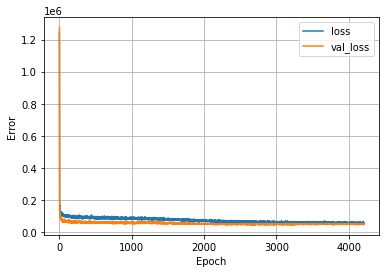

In [19]:
hf.plot_loss(history)

6/6 [==============================] - 0s 1ms/step


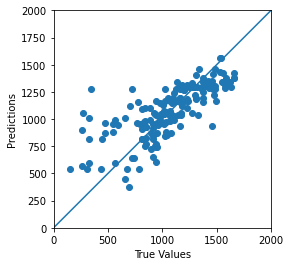

In [20]:
test_predictions = UTS_model.predict(UTS_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(UTS_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)